In [27]:
import numpy as np
import pandas as pd
import PcmPy as pcm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(0, '..')
import globals as gl

In [30]:
dataset = ['stroke',  'intact']
tinfo = pd.read_csv('../data/baseline/tinfo.tsv', sep='\t')
N = 40
Nc, Nd = 15, 21

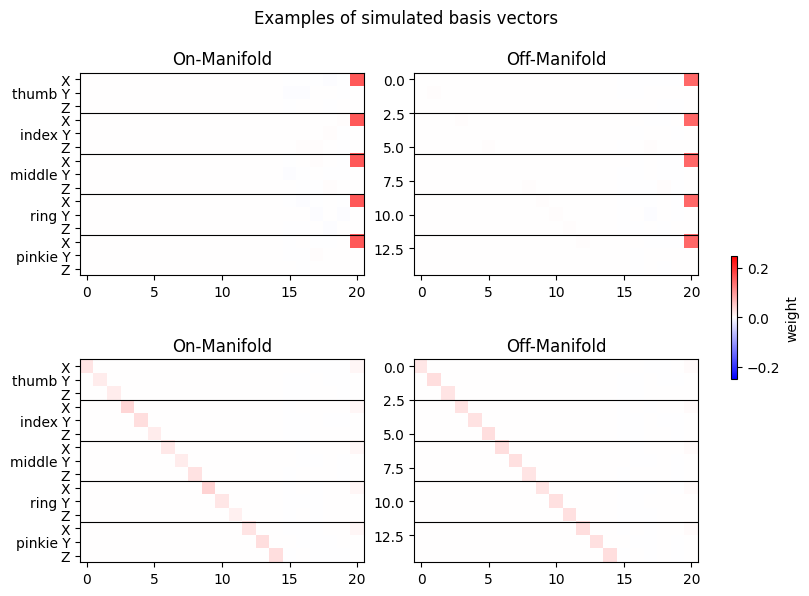

In [32]:
A_diff_on, A_diff_off = np.zeros((2, N, Nc, Nd)), np.zeros((2, N, Nc, Nd))
for d, ds in enumerate(dataset):
    for s, sn in enumerate(tinfo.subj_id.unique()):
        A0 = np.load(f'../data/basis_vectors/basis_vectors.{ds}.{sn}.npy')
        A_on = np.load(f'../data/post_rehab/basis_vectors.on-manifold.{ds}.{sn}.npy')
        A_off = np.load(f'../data/post_rehab/basis_vectors.off-manifold.{ds}.{sn}.npy')
        A_diff_on[d, s] = A_on - A0
        A_diff_off[d, s] = A_off - A0

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=[8, 6])

for d in range(len(dataset)):
    ax = axs[d]
    ax[0].imshow(A_diff_on[d].mean(axis=0), vmin=-.25, vmax=.25, cmap='bwr')
    ax[1].imshow(A_diff_off[d].mean(axis=0), vmin=-.25, vmax=.25, cmap='bwr')
    ax[0].set_title('On-Manifold')
    ax[1].set_title('Off-Manifold')
    ax[0].set_yticks(np.arange(0, Nc))
    ax[0].set_yticklabels(gl.channels)
    for a in ax:
        for i in [2.5, 5.5, 8.5, 11.5]:
            a.axhline(i, color='k', lw=.8)

cax = axs[0, 0].get_images()[0]
cbar = fig.colorbar(cax, ax=axs, orientation='vertical', fraction=.01)
cbar.set_label('weight')

fig.suptitle('Examples of simulated basis vectors')

plt.show()

In [38]:
A_diff_on[1, :, ::3, -1].mean()

np.float64(0.009588629436608055)

In [35]:
A_diff_off[0, :, ::3, -1].mean()

np.float64(0.14817411130557384)